In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import MapModelConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap, plot_reconstructed_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.tracking.batch_tracking import ScanDataBatch, BatchPositionOptimizerConfig, BatchPositionOptimizer
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
laser_data_list = dataset_loader.load(datafile)

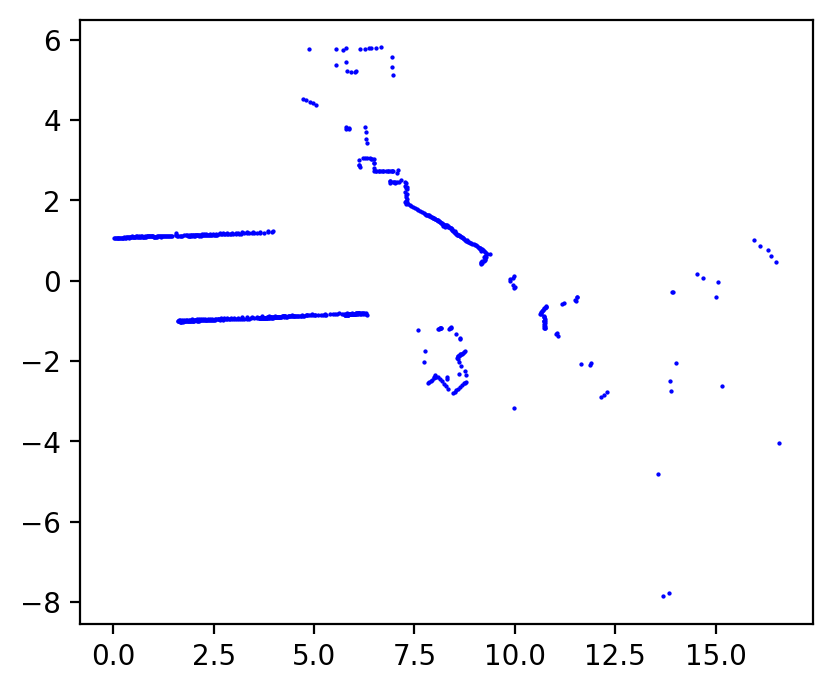

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[10:20:2], c="blue");

# Build map

In [31]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=0.2,
    F=4,
    L=32,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=1.,
    huber_delta=2
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=1e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)

learning_index = 6
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_model = map_builder.build_map(laser_data, map_position)

Compilation take 3.114873170852661 s


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.61it/s]


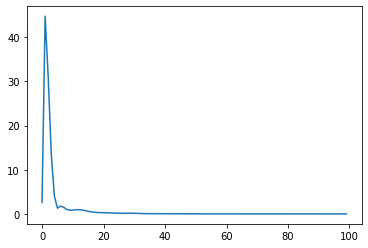

In [32]:
plt.plot(map_builder.loss_history)

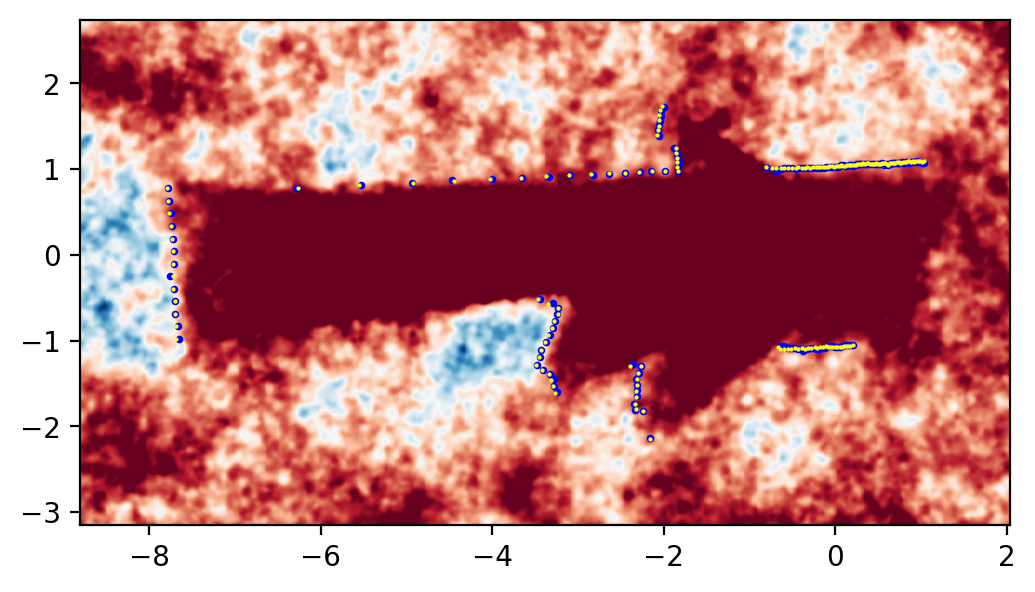

In [33]:
plt.figure(dpi=200)
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=0, 
                   vmin=0, vmax=None)

plot_reconstructed_result(laser_data_list[learning_index], map_model_config, mlp_model, 
                          map_model, s=3)
show_points(laser_data_list[learning_index:learning_index + 1], c="yellow");

# Make local BA SLAM

In [34]:
import jax.random

In [152]:
position_optimization_config = BatchPositionOptimizerConfig(
    iterations=100,
    init_hessian = jnp.diag(jnp.array([2000, 2000, 15000])),
    maximal_clip_norm = 50,
    beta1 = 0.9,
    beta2 = 0.5,
    hessian_adder = jnp.diag(jnp.array([10, 10, 10])),
    batch_size = 5,
    learning_rate=0.1,
)

In [153]:
def init_positions(data_list):
    result = jnp.array([x.odometry_position.as_vec() for x in data_list]).reshape(-1)
    result += jax.random.normal(jax.random.PRNGKey(0), result.shape) * 0
    return result


In [154]:
iterations = 1000
batch_size = 5
position_optimization_config.batch_size = batch_size
local_data_list = laser_data_list[10:20:2][:batch_size]
optimized_positions = init_positions(local_data_list)
map_model = init_map_model(mlp_model, map_model_config)

scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)
mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
map_builder.setup(scan_data_batch.scan_data, map_model, mapping_positions)

position_optimizer = BatchPositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer.setup()

postion_optimizer_states = []
for i in tqdm.tqdm(range(iterations)):
    scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
    mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
    new_map_model = map_builder.step(map_model, mapping_positions, scan_data_batch.scan_data)
    if i > 20:
        optimized_positions = position_optimizer.step(optimized_positions, map_model, scan_data_batch)
    postion_optimizer_states.append(position_optimizer.state)
    map_model = new_map_model
reconstructed_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions.reshape(-1, 3)]

Compilation take 2.5495522022247314 s


100%|███████████████████████████████████████| 1000/1000 [02:02<00:00,  8.20it/s]


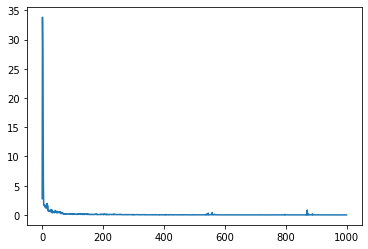

In [155]:
plt.plot(map_builder.loss_history)

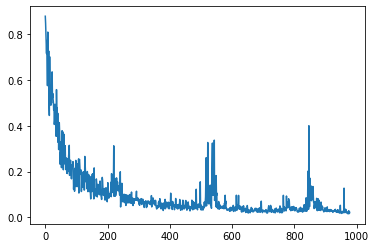

In [156]:
plt.plot(position_optimizer.loss_history)

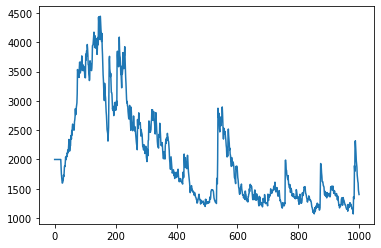

In [174]:
data = [x.previous_hessian[6, 6] for x in postion_optimizer_states]
plt.plot(data)

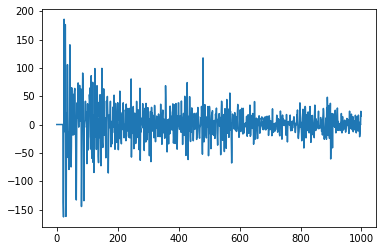

In [171]:
data = [x.previous_grad[5] for x in postion_optimizer_states]
plt.plot(data)

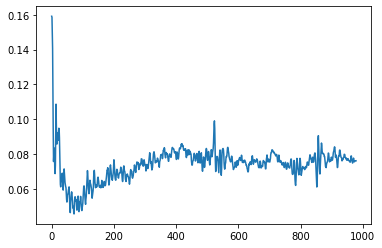

In [164]:
data = [x.y for x in position_optimizer.position_history]
plt.plot(data)

In [160]:
def get_points_from_laser_data_list(data_list):
    all_points = []
    for laser_data in data_list:
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    return points

def plot_scans_at_positions(data_list, positions, c="green"):
    all_points = []
    for position, laser_data in zip(positions, data_list):
        all_points.append(position.apply(laser_data.as_points()))
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.5, c=c)
    return points

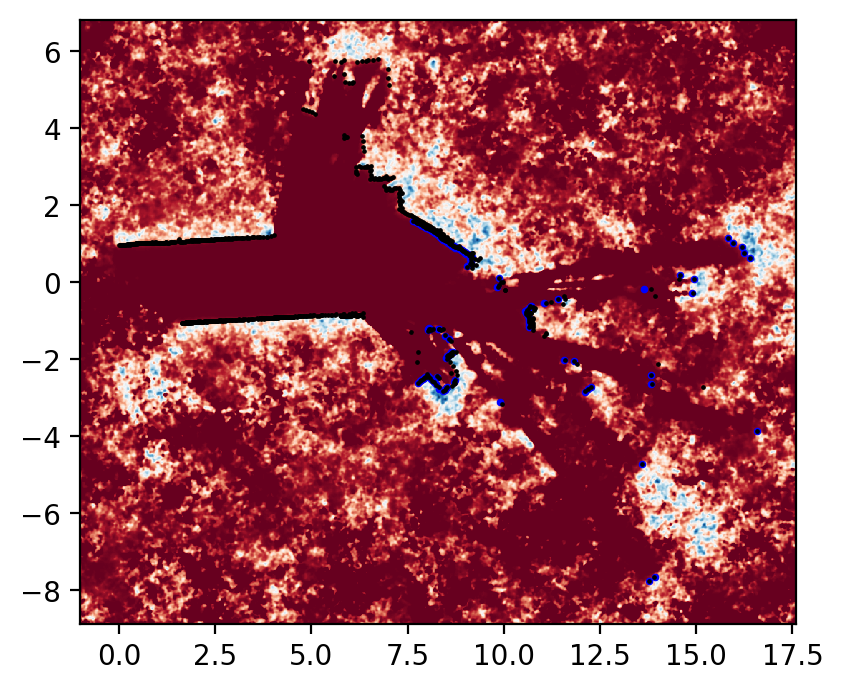

In [169]:
plt.figure(dpi=200)
points = get_points_from_laser_data_list(local_data_list)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), 
                   vmin=0, vmax=None)
index=4
plot_reconstructed_result(local_data_list[index], map_model_config, mlp_model, 
                          map_model, s=3, position=reconstructed_positions[index])
plot_scans_at_positions(local_data_list, reconstructed_positions, c="black");
# show_points(local_data_list, c="yellow");

In [19]:
list(range(10, 20, 2))

[10, 12, 14, 16, 18]